# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Extracting mnist: 100%|██████████| 60.0K/60.0K [00:14<00:00, 4.19KFile/s]


Extracting celeba...


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

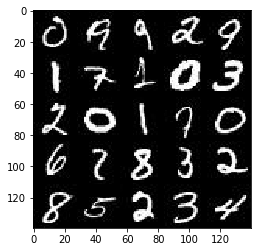

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

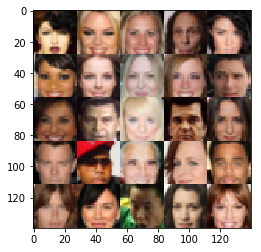

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    input_real = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), name='input_real')
    input_z = tf.placeholder(tf.float32, (None, z_dim), name='input_z')
    lr = tf.placeholder(tf.float32, name='learn_rate')

    return input_real, input_z, lr


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [6]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    with tf.variable_scope('discriminator', reuse=reuse):
        alpha = 0.2
        x1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same', 
                              kernel_initializer=tf.contrib.layers.xavier_initializer())
        x1 = tf.maximum(alpha * x1, x1)
        # now is 14*14*64
        
        x2 = tf.layers.conv2d(x1, 128, 5, strides=2, padding='same', 
                              kernel_initializer=tf.contrib.layers.xavier_initializer())
        x2 = tf.layers.batch_normalization(x2, training=True)
        x2 = tf.maximum(alpha * x2, x2)
        x2 = tf.nn.dropout(x2, keep_prob=0.5)
        # now is 7*7*128
        
        x3 = tf.layers.conv2d(x2, 256, 5, strides=2, padding='same', 
                              kernel_initializer=tf.contrib.layers.xavier_initializer())
        x3 = tf.layers.batch_normalization(x3, training=True)
        x3 = tf.maximum(alpha * x3, x3)
        x3 = tf.nn.dropout(x3, keep_prob=0.5)
        # now is 4*4*256
        
        # flatten
        flat = tf.reshape(x3, (-1, 4*4*256))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)

    return out, logits



"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    with tf.variable_scope('generator', reuse = not is_train):
        alpha = 0.2
        # Fully connected layer
        x1 = tf.layers.dense(z, 7*7*512)
        
        x1 = tf.reshape(x1, (-1, 7,7,512))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(alpha * x1, x1)
        # 7*7*512
        
        x2 = tf.layers.conv2d_transpose(x1, 256, 5, strides=2, padding='same')
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(alpha * x2, x2)
        # 14*14*256
        
        x3 = tf.layers.conv2d_transpose(x2, 128, 5, strides=2, padding='same')
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = tf.maximum(alpha * x3, x3)
        # 28*28*128
        
        logits = tf.layers.conv2d_transpose(x3, out_channel_dim, 3, strides=1, padding='same')
        # 28*28* out_channel_dim
        
        output = tf.tanh(logits)
    
    return output


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    smooth = 0.1
    
    g_model = generator(input_z, out_channel_dim, is_train=True)
    d_model_real, d_logits_real = discriminator(input_real, reuse=False)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)
    
    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, 
                                                labels=tf.ones_like(d_model_real)*(1 - smooth)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, 
                                                labels=tf.zeros_like(d_model_fake)*(1 - smooth)))
    
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, 
                                                labels=tf.ones_like(d_model_fake)*(1 - smooth)))
    
    d_loss = d_loss_real + d_loss_fake
    
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [11]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    _, image_width, image_height, image_channels = data_shape
    out_channel_dim = image_channels
    
    input_real, input_z, lrate = model_inputs(image_width,image_height,image_channels,z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, out_channel_dim)
    d_train_opt, g_train_opt = model_opt(d_loss, g_loss, learning_rate, beta1) 
    
    steps = 0
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                steps += 1
                
                batch_images = batch_images.reshape(batch_size, data_shape[1], data_shape[2], data_shape[3])
                batch_images = batch_images*2
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                
                _ = sess.run(d_train_opt, feed_dict={input_real: batch_images,input_z: batch_z,lrate:learning_rate})
                _ = sess.run(g_train_opt, feed_dict={input_real: batch_images,input_z: batch_z,lrate:learning_rate})
                
                if steps %10 == 0:
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})
                    
                    print("Epoch {}/{}...".format(epoch_i+1, epochs),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    
                if steps%100 == 0:
                    show_generator_output(sess, 25, input_z, out_channel_dim, data_image_mode)
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 0.5259... Generator Loss: 11.3315
Epoch 1/2... Discriminator Loss: 0.3899... Generator Loss: 7.3569
Epoch 1/2... Discriminator Loss: 0.4152... Generator Loss: 7.0665
Epoch 1/2... Discriminator Loss: 0.3879... Generator Loss: 6.6778
Epoch 1/2... Discriminator Loss: 1.9420... Generator Loss: 0.5262
Epoch 1/2... Discriminator Loss: 1.9572... Generator Loss: 4.8245
Epoch 1/2... Discriminator Loss: 1.5734... Generator Loss: 2.6190
Epoch 1/2... Discriminator Loss: 0.8969... Generator Loss: 2.3103
Epoch 1/2... Discriminator Loss: 1.2902... Generator Loss: 2.4262
Epoch 1/2... Discriminator Loss: 1.0888... Generator Loss: 1.2078


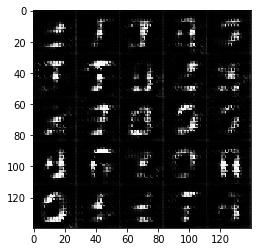

Epoch 1/2... Discriminator Loss: 1.8424... Generator Loss: 2.4051
Epoch 1/2... Discriminator Loss: 0.9158... Generator Loss: 1.8915
Epoch 1/2... Discriminator Loss: 1.9270... Generator Loss: 0.4589
Epoch 1/2... Discriminator Loss: 1.0077... Generator Loss: 1.1737
Epoch 1/2... Discriminator Loss: 1.2944... Generator Loss: 0.7460
Epoch 1/2... Discriminator Loss: 1.5088... Generator Loss: 1.7429
Epoch 1/2... Discriminator Loss: 1.3948... Generator Loss: 1.6723
Epoch 1/2... Discriminator Loss: 1.3748... Generator Loss: 0.7976
Epoch 1/2... Discriminator Loss: 2.2504... Generator Loss: 1.8623
Epoch 1/2... Discriminator Loss: 1.0862... Generator Loss: 1.0099


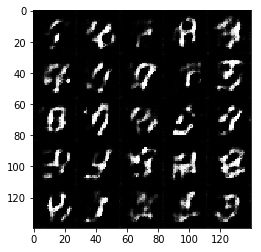

Epoch 1/2... Discriminator Loss: 1.0791... Generator Loss: 1.1079
Epoch 1/2... Discriminator Loss: 1.3462... Generator Loss: 0.7733
Epoch 1/2... Discriminator Loss: 1.5150... Generator Loss: 1.0033
Epoch 1/2... Discriminator Loss: 1.5686... Generator Loss: 1.3017
Epoch 1/2... Discriminator Loss: 1.2364... Generator Loss: 0.9041
Epoch 1/2... Discriminator Loss: 1.3154... Generator Loss: 0.9197
Epoch 1/2... Discriminator Loss: 1.2412... Generator Loss: 1.1602
Epoch 1/2... Discriminator Loss: 1.2304... Generator Loss: 1.1031
Epoch 1/2... Discriminator Loss: 1.4901... Generator Loss: 1.1464
Epoch 1/2... Discriminator Loss: 1.4491... Generator Loss: 1.0426


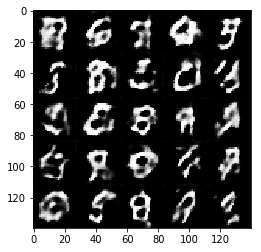

Epoch 1/2... Discriminator Loss: 1.2436... Generator Loss: 0.9351
Epoch 1/2... Discriminator Loss: 1.2447... Generator Loss: 0.7878
Epoch 1/2... Discriminator Loss: 1.3093... Generator Loss: 1.2530
Epoch 1/2... Discriminator Loss: 1.0977... Generator Loss: 1.3262
Epoch 1/2... Discriminator Loss: 1.2793... Generator Loss: 0.8277
Epoch 1/2... Discriminator Loss: 1.3648... Generator Loss: 0.9610
Epoch 1/2... Discriminator Loss: 1.2073... Generator Loss: 1.3541
Epoch 1/2... Discriminator Loss: 1.2285... Generator Loss: 1.0882
Epoch 1/2... Discriminator Loss: 1.4487... Generator Loss: 1.4602
Epoch 1/2... Discriminator Loss: 1.1320... Generator Loss: 0.7810


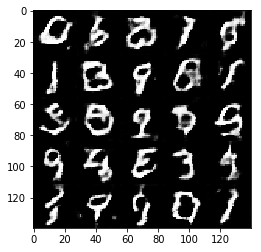

Epoch 1/2... Discriminator Loss: 1.0988... Generator Loss: 1.1145
Epoch 1/2... Discriminator Loss: 1.1209... Generator Loss: 0.9896
Epoch 1/2... Discriminator Loss: 1.2268... Generator Loss: 0.8133
Epoch 1/2... Discriminator Loss: 1.3344... Generator Loss: 0.7668
Epoch 1/2... Discriminator Loss: 1.3975... Generator Loss: 0.9443
Epoch 1/2... Discriminator Loss: 1.3435... Generator Loss: 0.9432
Epoch 1/2... Discriminator Loss: 1.2369... Generator Loss: 1.0269
Epoch 1/2... Discriminator Loss: 1.2040... Generator Loss: 1.0682
Epoch 1/2... Discriminator Loss: 1.3480... Generator Loss: 1.0223
Epoch 1/2... Discriminator Loss: 1.2796... Generator Loss: 1.0870


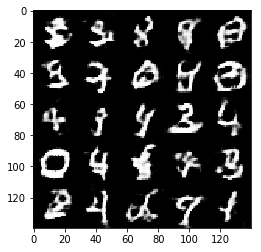

Epoch 1/2... Discriminator Loss: 1.2414... Generator Loss: 1.0976
Epoch 1/2... Discriminator Loss: 1.2540... Generator Loss: 1.0927
Epoch 1/2... Discriminator Loss: 1.3368... Generator Loss: 0.8547
Epoch 1/2... Discriminator Loss: 1.2512... Generator Loss: 0.7632
Epoch 1/2... Discriminator Loss: 1.2707... Generator Loss: 1.1533
Epoch 1/2... Discriminator Loss: 1.3150... Generator Loss: 1.3038
Epoch 1/2... Discriminator Loss: 1.2974... Generator Loss: 1.3454
Epoch 1/2... Discriminator Loss: 1.2851... Generator Loss: 0.8585
Epoch 1/2... Discriminator Loss: 1.3540... Generator Loss: 0.9973
Epoch 1/2... Discriminator Loss: 1.2728... Generator Loss: 0.8882


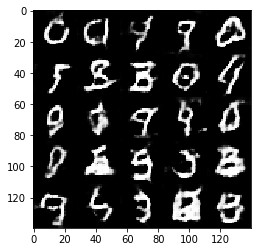

Epoch 1/2... Discriminator Loss: 1.2428... Generator Loss: 0.9284
Epoch 1/2... Discriminator Loss: 1.3360... Generator Loss: 0.9093
Epoch 1/2... Discriminator Loss: 1.2808... Generator Loss: 0.8629
Epoch 1/2... Discriminator Loss: 1.2539... Generator Loss: 1.1311
Epoch 1/2... Discriminator Loss: 1.1934... Generator Loss: 1.1158
Epoch 1/2... Discriminator Loss: 1.4098... Generator Loss: 1.3640
Epoch 1/2... Discriminator Loss: 1.2564... Generator Loss: 1.0524
Epoch 1/2... Discriminator Loss: 1.2991... Generator Loss: 1.1146
Epoch 1/2... Discriminator Loss: 1.2062... Generator Loss: 0.8128
Epoch 1/2... Discriminator Loss: 1.2452... Generator Loss: 1.1033


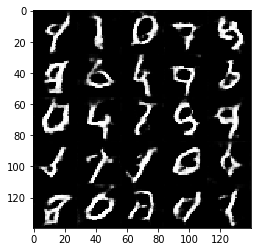

Epoch 1/2... Discriminator Loss: 1.3925... Generator Loss: 1.2835
Epoch 1/2... Discriminator Loss: 1.2178... Generator Loss: 1.1651
Epoch 1/2... Discriminator Loss: 1.3406... Generator Loss: 0.9989
Epoch 1/2... Discriminator Loss: 1.4496... Generator Loss: 0.8641
Epoch 1/2... Discriminator Loss: 1.3614... Generator Loss: 1.1339
Epoch 1/2... Discriminator Loss: 1.3625... Generator Loss: 1.0424
Epoch 1/2... Discriminator Loss: 1.1189... Generator Loss: 1.3642
Epoch 1/2... Discriminator Loss: 1.2828... Generator Loss: 0.7963
Epoch 1/2... Discriminator Loss: 1.3694... Generator Loss: 0.7654
Epoch 1/2... Discriminator Loss: 1.2686... Generator Loss: 0.9074


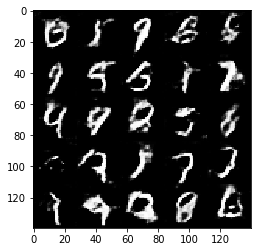

Epoch 1/2... Discriminator Loss: 1.4818... Generator Loss: 0.7607
Epoch 1/2... Discriminator Loss: 1.4506... Generator Loss: 0.8615
Epoch 1/2... Discriminator Loss: 1.4672... Generator Loss: 0.8110
Epoch 1/2... Discriminator Loss: 1.4362... Generator Loss: 0.7803
Epoch 1/2... Discriminator Loss: 1.4065... Generator Loss: 0.9385
Epoch 1/2... Discriminator Loss: 1.3441... Generator Loss: 0.8170
Epoch 1/2... Discriminator Loss: 1.2880... Generator Loss: 0.9540
Epoch 1/2... Discriminator Loss: 1.3034... Generator Loss: 1.1665
Epoch 1/2... Discriminator Loss: 1.4810... Generator Loss: 0.6309
Epoch 1/2... Discriminator Loss: 1.3786... Generator Loss: 0.7063


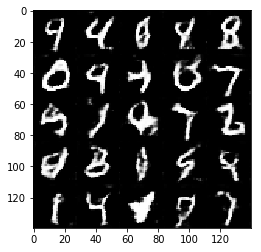

Epoch 1/2... Discriminator Loss: 1.3069... Generator Loss: 1.0331
Epoch 1/2... Discriminator Loss: 1.1767... Generator Loss: 1.1814
Epoch 1/2... Discriminator Loss: 1.2029... Generator Loss: 0.8587
Epoch 2/2... Discriminator Loss: 1.2796... Generator Loss: 0.8630
Epoch 2/2... Discriminator Loss: 1.6434... Generator Loss: 0.6421
Epoch 2/2... Discriminator Loss: 1.2585... Generator Loss: 0.9610
Epoch 2/2... Discriminator Loss: 1.3304... Generator Loss: 0.7095
Epoch 2/2... Discriminator Loss: 1.3209... Generator Loss: 0.9268
Epoch 2/2... Discriminator Loss: 1.1402... Generator Loss: 0.8360
Epoch 2/2... Discriminator Loss: 1.3082... Generator Loss: 1.2280


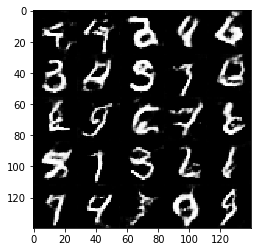

Epoch 2/2... Discriminator Loss: 1.3813... Generator Loss: 0.7700
Epoch 2/2... Discriminator Loss: 1.1502... Generator Loss: 1.0390
Epoch 2/2... Discriminator Loss: 1.2171... Generator Loss: 0.9750
Epoch 2/2... Discriminator Loss: 1.2738... Generator Loss: 1.1667
Epoch 2/2... Discriminator Loss: 1.2444... Generator Loss: 1.0395
Epoch 2/2... Discriminator Loss: 1.2972... Generator Loss: 0.9993
Epoch 2/2... Discriminator Loss: 1.4342... Generator Loss: 1.2012
Epoch 2/2... Discriminator Loss: 1.2160... Generator Loss: 0.7780
Epoch 2/2... Discriminator Loss: 1.3159... Generator Loss: 1.0773
Epoch 2/2... Discriminator Loss: 1.5391... Generator Loss: 0.5966


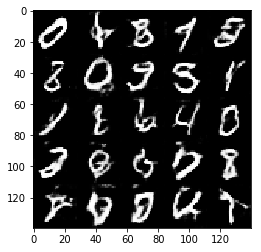

Epoch 2/2... Discriminator Loss: 1.2574... Generator Loss: 1.0260
Epoch 2/2... Discriminator Loss: 1.3038... Generator Loss: 1.1019
Epoch 2/2... Discriminator Loss: 1.2197... Generator Loss: 0.7959
Epoch 2/2... Discriminator Loss: 1.2960... Generator Loss: 1.2133
Epoch 2/2... Discriminator Loss: 1.3378... Generator Loss: 0.7985
Epoch 2/2... Discriminator Loss: 1.2592... Generator Loss: 0.7569
Epoch 2/2... Discriminator Loss: 1.2456... Generator Loss: 0.9170
Epoch 2/2... Discriminator Loss: 1.1604... Generator Loss: 0.8095
Epoch 2/2... Discriminator Loss: 1.3632... Generator Loss: 0.7369
Epoch 2/2... Discriminator Loss: 1.2107... Generator Loss: 0.9992


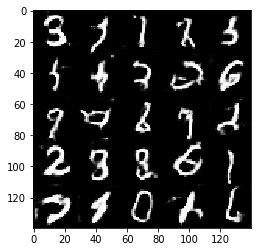

Epoch 2/2... Discriminator Loss: 1.3036... Generator Loss: 0.8546
Epoch 2/2... Discriminator Loss: 1.4474... Generator Loss: 0.5930
Epoch 2/2... Discriminator Loss: 1.4256... Generator Loss: 0.9266
Epoch 2/2... Discriminator Loss: 1.2872... Generator Loss: 0.9102
Epoch 2/2... Discriminator Loss: 1.3880... Generator Loss: 1.1702
Epoch 2/2... Discriminator Loss: 1.3192... Generator Loss: 1.5246
Epoch 2/2... Discriminator Loss: 1.2707... Generator Loss: 1.0729
Epoch 2/2... Discriminator Loss: 1.2652... Generator Loss: 1.1606
Epoch 2/2... Discriminator Loss: 1.2135... Generator Loss: 0.8887
Epoch 2/2... Discriminator Loss: 1.1719... Generator Loss: 1.1993


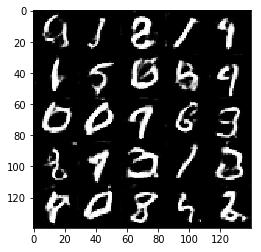

Epoch 2/2... Discriminator Loss: 1.2170... Generator Loss: 0.7890
Epoch 2/2... Discriminator Loss: 1.3992... Generator Loss: 0.8850
Epoch 2/2... Discriminator Loss: 1.2934... Generator Loss: 0.8410
Epoch 2/2... Discriminator Loss: 1.5203... Generator Loss: 0.5726
Epoch 2/2... Discriminator Loss: 1.1965... Generator Loss: 1.2447
Epoch 2/2... Discriminator Loss: 1.1765... Generator Loss: 0.9362
Epoch 2/2... Discriminator Loss: 1.4566... Generator Loss: 1.4244
Epoch 2/2... Discriminator Loss: 1.3134... Generator Loss: 0.8653
Epoch 2/2... Discriminator Loss: 1.3038... Generator Loss: 1.0032
Epoch 2/2... Discriminator Loss: 1.2179... Generator Loss: 0.8553


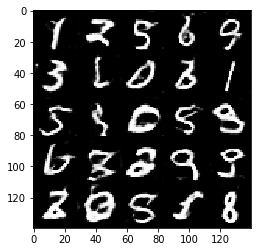

Epoch 2/2... Discriminator Loss: 1.3456... Generator Loss: 0.8437
Epoch 2/2... Discriminator Loss: 1.2856... Generator Loss: 0.8956
Epoch 2/2... Discriminator Loss: 1.1975... Generator Loss: 0.9849
Epoch 2/2... Discriminator Loss: 1.2247... Generator Loss: 0.8976
Epoch 2/2... Discriminator Loss: 1.4093... Generator Loss: 0.7884
Epoch 2/2... Discriminator Loss: 1.4988... Generator Loss: 1.4858
Epoch 2/2... Discriminator Loss: 1.2538... Generator Loss: 1.1827
Epoch 2/2... Discriminator Loss: 1.2993... Generator Loss: 0.8160
Epoch 2/2... Discriminator Loss: 1.3506... Generator Loss: 0.7682
Epoch 2/2... Discriminator Loss: 1.3142... Generator Loss: 0.8911


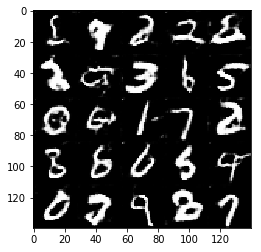

Epoch 2/2... Discriminator Loss: 1.3894... Generator Loss: 0.9401
Epoch 2/2... Discriminator Loss: 1.1727... Generator Loss: 0.7804
Epoch 2/2... Discriminator Loss: 1.1405... Generator Loss: 1.0433
Epoch 2/2... Discriminator Loss: 1.2495... Generator Loss: 0.9150
Epoch 2/2... Discriminator Loss: 1.4563... Generator Loss: 0.6326
Epoch 2/2... Discriminator Loss: 1.3784... Generator Loss: 0.8030
Epoch 2/2... Discriminator Loss: 1.3321... Generator Loss: 1.5106
Epoch 2/2... Discriminator Loss: 1.1925... Generator Loss: 0.8216
Epoch 2/2... Discriminator Loss: 1.2344... Generator Loss: 0.8988
Epoch 2/2... Discriminator Loss: 1.1550... Generator Loss: 1.1871


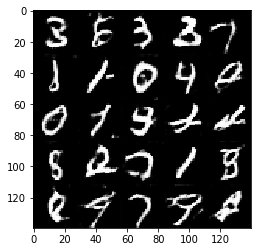

Epoch 2/2... Discriminator Loss: 1.4264... Generator Loss: 0.6007
Epoch 2/2... Discriminator Loss: 1.3231... Generator Loss: 0.8209
Epoch 2/2... Discriminator Loss: 1.5497... Generator Loss: 1.8388
Epoch 2/2... Discriminator Loss: 1.1505... Generator Loss: 1.2346
Epoch 2/2... Discriminator Loss: 1.2263... Generator Loss: 0.8413
Epoch 2/2... Discriminator Loss: 1.1925... Generator Loss: 1.0484
Epoch 2/2... Discriminator Loss: 1.4522... Generator Loss: 0.8090
Epoch 2/2... Discriminator Loss: 1.2559... Generator Loss: 0.7495
Epoch 2/2... Discriminator Loss: 1.2238... Generator Loss: 0.9066
Epoch 2/2... Discriminator Loss: 1.0877... Generator Loss: 1.1622


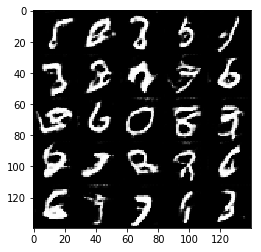

Epoch 2/2... Discriminator Loss: 1.2544... Generator Loss: 1.0139
Epoch 2/2... Discriminator Loss: 1.2661... Generator Loss: 0.8730
Epoch 2/2... Discriminator Loss: 1.3329... Generator Loss: 0.8138
Epoch 2/2... Discriminator Loss: 1.3310... Generator Loss: 1.1274
Epoch 2/2... Discriminator Loss: 1.2276... Generator Loss: 0.9682
Epoch 2/2... Discriminator Loss: 1.1108... Generator Loss: 1.1906
Epoch 2/2... Discriminator Loss: 1.3608... Generator Loss: 1.0717
Epoch 2/2... Discriminator Loss: 1.1256... Generator Loss: 1.0788
Epoch 2/2... Discriminator Loss: 1.5333... Generator Loss: 0.8645
Epoch 2/2... Discriminator Loss: 1.3326... Generator Loss: 0.6801


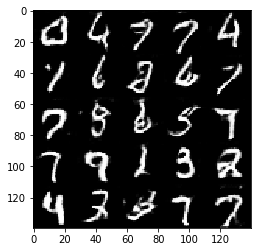

Epoch 2/2... Discriminator Loss: 1.0348... Generator Loss: 0.8923
Epoch 2/2... Discriminator Loss: 1.1507... Generator Loss: 1.2531
Epoch 2/2... Discriminator Loss: 1.3863... Generator Loss: 0.9756
Epoch 2/2... Discriminator Loss: 1.3234... Generator Loss: 0.8732
Epoch 2/2... Discriminator Loss: 1.3136... Generator Loss: 1.1389
Epoch 2/2... Discriminator Loss: 1.1627... Generator Loss: 1.1120
Epoch 2/2... Discriminator Loss: 1.3678... Generator Loss: 0.8405


In [12]:
batch_size = 64
z_dim =100
learning_rate = 0.001 # 0.0002 to 0.001 , to accelate the training
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 0.8169... Generator Loss: 1.5176
Epoch 1/1... Discriminator Loss: 1.0553... Generator Loss: 1.5866
Epoch 1/1... Discriminator Loss: 0.9424... Generator Loss: 1.6735
Epoch 1/1... Discriminator Loss: 0.8014... Generator Loss: 1.8809
Epoch 1/1... Discriminator Loss: 0.6787... Generator Loss: 2.3651
Epoch 1/1... Discriminator Loss: 1.2798... Generator Loss: 1.3851
Epoch 1/1... Discriminator Loss: 1.5199... Generator Loss: 0.9833
Epoch 1/1... Discriminator Loss: 1.1224... Generator Loss: 2.4260
Epoch 1/1... Discriminator Loss: 0.9725... Generator Loss: 1.6151
Epoch 1/1... Discriminator Loss: 0.8167... Generator Loss: 1.7121


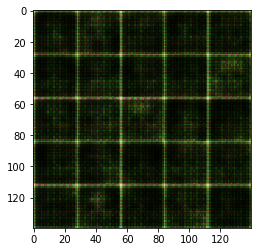

Epoch 1/1... Discriminator Loss: 0.8879... Generator Loss: 1.8358
Epoch 1/1... Discriminator Loss: 0.7264... Generator Loss: 2.0084
Epoch 1/1... Discriminator Loss: 1.8143... Generator Loss: 0.7460
Epoch 1/1... Discriminator Loss: 0.9156... Generator Loss: 2.1268
Epoch 1/1... Discriminator Loss: 1.0157... Generator Loss: 1.0966
Epoch 1/1... Discriminator Loss: 1.0549... Generator Loss: 1.4727
Epoch 1/1... Discriminator Loss: 1.6425... Generator Loss: 0.7801
Epoch 1/1... Discriminator Loss: 1.2081... Generator Loss: 1.7368
Epoch 1/1... Discriminator Loss: 1.9544... Generator Loss: 0.6768
Epoch 1/1... Discriminator Loss: 0.8187... Generator Loss: 2.5342


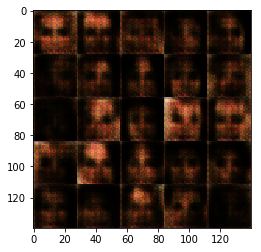

Epoch 1/1... Discriminator Loss: 0.7856... Generator Loss: 2.8952
Epoch 1/1... Discriminator Loss: 0.8017... Generator Loss: 2.0357
Epoch 1/1... Discriminator Loss: 0.6256... Generator Loss: 3.0762
Epoch 1/1... Discriminator Loss: 1.1181... Generator Loss: 3.0432
Epoch 1/1... Discriminator Loss: 0.8974... Generator Loss: 2.1323
Epoch 1/1... Discriminator Loss: 0.9464... Generator Loss: 4.0898
Epoch 1/1... Discriminator Loss: 1.4450... Generator Loss: 2.8980
Epoch 1/1... Discriminator Loss: 1.1971... Generator Loss: 1.0730
Epoch 1/1... Discriminator Loss: 1.0763... Generator Loss: 3.4087
Epoch 1/1... Discriminator Loss: 0.9205... Generator Loss: 1.3058


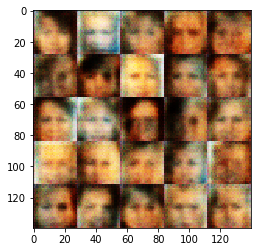

Epoch 1/1... Discriminator Loss: 0.5690... Generator Loss: 2.1546
Epoch 1/1... Discriminator Loss: 1.2609... Generator Loss: 3.0698
Epoch 1/1... Discriminator Loss: 2.9469... Generator Loss: 0.4422
Epoch 1/1... Discriminator Loss: 1.0219... Generator Loss: 1.9638
Epoch 1/1... Discriminator Loss: 0.6103... Generator Loss: 2.4269
Epoch 1/1... Discriminator Loss: 0.6235... Generator Loss: 2.8728
Epoch 1/1... Discriminator Loss: 1.5016... Generator Loss: 0.9463
Epoch 1/1... Discriminator Loss: 0.8571... Generator Loss: 4.1725
Epoch 1/1... Discriminator Loss: 1.2908... Generator Loss: 1.7674
Epoch 1/1... Discriminator Loss: 1.1995... Generator Loss: 1.0110


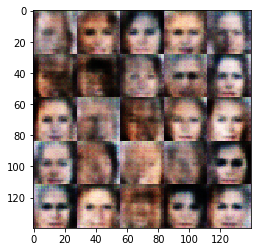

Epoch 1/1... Discriminator Loss: 0.6807... Generator Loss: 2.2008
Epoch 1/1... Discriminator Loss: 1.5877... Generator Loss: 1.1293
Epoch 1/1... Discriminator Loss: 1.5314... Generator Loss: 0.9018
Epoch 1/1... Discriminator Loss: 2.1920... Generator Loss: 0.4183
Epoch 1/1... Discriminator Loss: 1.8076... Generator Loss: 0.8230
Epoch 1/1... Discriminator Loss: 1.3687... Generator Loss: 1.3041
Epoch 1/1... Discriminator Loss: 0.8451... Generator Loss: 2.3388
Epoch 1/1... Discriminator Loss: 1.2177... Generator Loss: 1.6419
Epoch 1/1... Discriminator Loss: 1.0661... Generator Loss: 1.6480
Epoch 1/1... Discriminator Loss: 1.5924... Generator Loss: 0.8112


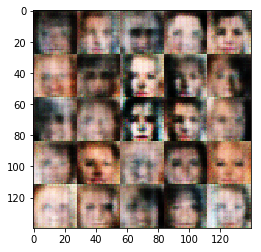

Epoch 1/1... Discriminator Loss: 1.3224... Generator Loss: 1.1939
Epoch 1/1... Discriminator Loss: 1.3854... Generator Loss: 1.5896
Epoch 1/1... Discriminator Loss: 1.7783... Generator Loss: 0.9024
Epoch 1/1... Discriminator Loss: 1.4621... Generator Loss: 1.0543
Epoch 1/1... Discriminator Loss: 1.2627... Generator Loss: 0.9673
Epoch 1/1... Discriminator Loss: 1.5007... Generator Loss: 0.7675
Epoch 1/1... Discriminator Loss: 1.2786... Generator Loss: 1.0842
Epoch 1/1... Discriminator Loss: 1.3930... Generator Loss: 1.4790
Epoch 1/1... Discriminator Loss: 1.5788... Generator Loss: 0.8606
Epoch 1/1... Discriminator Loss: 1.5082... Generator Loss: 1.0308


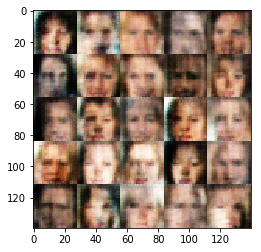

Epoch 1/1... Discriminator Loss: 1.5154... Generator Loss: 1.0704
Epoch 1/1... Discriminator Loss: 1.6381... Generator Loss: 1.0867
Epoch 1/1... Discriminator Loss: 1.4662... Generator Loss: 0.9470
Epoch 1/1... Discriminator Loss: 1.4491... Generator Loss: 0.8520
Epoch 1/1... Discriminator Loss: 1.4050... Generator Loss: 0.8855
Epoch 1/1... Discriminator Loss: 1.4306... Generator Loss: 0.8070
Epoch 1/1... Discriminator Loss: 1.5557... Generator Loss: 0.9350
Epoch 1/1... Discriminator Loss: 1.3570... Generator Loss: 1.1636
Epoch 1/1... Discriminator Loss: 1.5157... Generator Loss: 0.7454
Epoch 1/1... Discriminator Loss: 1.4428... Generator Loss: 1.1712


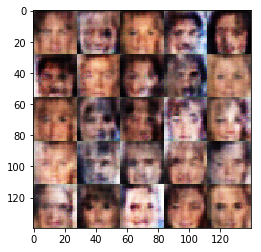

Epoch 1/1... Discriminator Loss: 1.2468... Generator Loss: 1.1902
Epoch 1/1... Discriminator Loss: 1.3636... Generator Loss: 0.7931
Epoch 1/1... Discriminator Loss: 1.3052... Generator Loss: 1.0882
Epoch 1/1... Discriminator Loss: 1.6982... Generator Loss: 0.6741
Epoch 1/1... Discriminator Loss: 1.4453... Generator Loss: 0.7330
Epoch 1/1... Discriminator Loss: 1.5673... Generator Loss: 0.9545
Epoch 1/1... Discriminator Loss: 1.4622... Generator Loss: 0.8188
Epoch 1/1... Discriminator Loss: 1.3127... Generator Loss: 0.8579
Epoch 1/1... Discriminator Loss: 1.4649... Generator Loss: 0.9870
Epoch 1/1... Discriminator Loss: 1.5562... Generator Loss: 0.7481


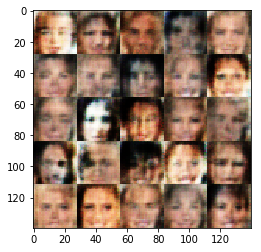

Epoch 1/1... Discriminator Loss: 1.5003... Generator Loss: 0.9466
Epoch 1/1... Discriminator Loss: 1.4812... Generator Loss: 1.1162
Epoch 1/1... Discriminator Loss: 1.5426... Generator Loss: 0.7882
Epoch 1/1... Discriminator Loss: 1.4421... Generator Loss: 0.7373
Epoch 1/1... Discriminator Loss: 1.4944... Generator Loss: 0.9058
Epoch 1/1... Discriminator Loss: 1.3530... Generator Loss: 0.8595
Epoch 1/1... Discriminator Loss: 1.5222... Generator Loss: 1.2389
Epoch 1/1... Discriminator Loss: 1.5920... Generator Loss: 0.7895
Epoch 1/1... Discriminator Loss: 1.4443... Generator Loss: 0.9847
Epoch 1/1... Discriminator Loss: 1.5612... Generator Loss: 0.7897


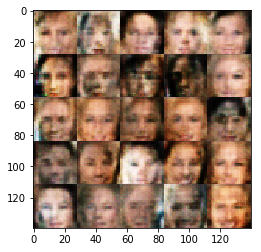

Epoch 1/1... Discriminator Loss: 1.5004... Generator Loss: 0.8233
Epoch 1/1... Discriminator Loss: 1.4338... Generator Loss: 0.9336
Epoch 1/1... Discriminator Loss: 1.4618... Generator Loss: 0.7789
Epoch 1/1... Discriminator Loss: 1.5058... Generator Loss: 0.9238
Epoch 1/1... Discriminator Loss: 1.5720... Generator Loss: 0.8036
Epoch 1/1... Discriminator Loss: 1.3856... Generator Loss: 0.7585
Epoch 1/1... Discriminator Loss: 1.4715... Generator Loss: 0.9334
Epoch 1/1... Discriminator Loss: 1.4462... Generator Loss: 0.9369
Epoch 1/1... Discriminator Loss: 1.4604... Generator Loss: 0.8577
Epoch 1/1... Discriminator Loss: 1.3448... Generator Loss: 0.7555


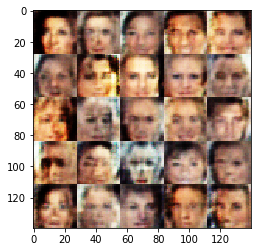

Epoch 1/1... Discriminator Loss: 1.5738... Generator Loss: 0.8797
Epoch 1/1... Discriminator Loss: 1.4850... Generator Loss: 0.8231
Epoch 1/1... Discriminator Loss: 1.5730... Generator Loss: 0.8212
Epoch 1/1... Discriminator Loss: 1.6450... Generator Loss: 0.8394
Epoch 1/1... Discriminator Loss: 1.3841... Generator Loss: 0.8734
Epoch 1/1... Discriminator Loss: 1.3640... Generator Loss: 0.7703
Epoch 1/1... Discriminator Loss: 1.4613... Generator Loss: 0.8687
Epoch 1/1... Discriminator Loss: 1.4215... Generator Loss: 0.8979
Epoch 1/1... Discriminator Loss: 1.3740... Generator Loss: 0.8336
Epoch 1/1... Discriminator Loss: 1.4474... Generator Loss: 0.8202


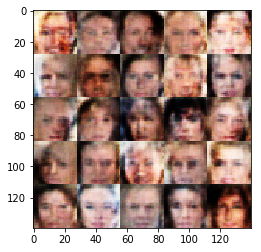

Epoch 1/1... Discriminator Loss: 1.5584... Generator Loss: 0.9441
Epoch 1/1... Discriminator Loss: 1.5712... Generator Loss: 0.7250
Epoch 1/1... Discriminator Loss: 1.3401... Generator Loss: 0.9099
Epoch 1/1... Discriminator Loss: 1.4502... Generator Loss: 0.9792
Epoch 1/1... Discriminator Loss: 1.2778... Generator Loss: 1.0137
Epoch 1/1... Discriminator Loss: 1.3887... Generator Loss: 0.8140
Epoch 1/1... Discriminator Loss: 1.3527... Generator Loss: 0.8274
Epoch 1/1... Discriminator Loss: 1.3515... Generator Loss: 0.8783
Epoch 1/1... Discriminator Loss: 1.2808... Generator Loss: 0.8811
Epoch 1/1... Discriminator Loss: 1.3084... Generator Loss: 0.8906


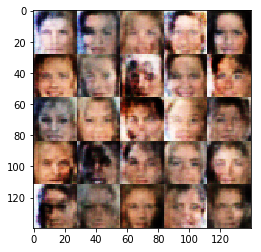

Epoch 1/1... Discriminator Loss: 1.4428... Generator Loss: 0.9225
Epoch 1/1... Discriminator Loss: 1.4636... Generator Loss: 0.8568
Epoch 1/1... Discriminator Loss: 1.5750... Generator Loss: 0.9975
Epoch 1/1... Discriminator Loss: 1.4896... Generator Loss: 0.9336
Epoch 1/1... Discriminator Loss: 1.3711... Generator Loss: 0.8987
Epoch 1/1... Discriminator Loss: 1.5775... Generator Loss: 0.9745
Epoch 1/1... Discriminator Loss: 1.5438... Generator Loss: 0.9380
Epoch 1/1... Discriminator Loss: 1.5981... Generator Loss: 0.7607
Epoch 1/1... Discriminator Loss: 1.4252... Generator Loss: 0.8867
Epoch 1/1... Discriminator Loss: 1.4719... Generator Loss: 0.8489


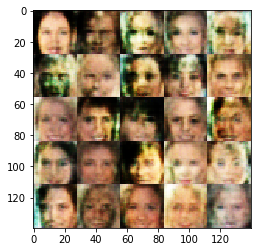

Epoch 1/1... Discriminator Loss: 1.2461... Generator Loss: 0.8569
Epoch 1/1... Discriminator Loss: 1.4560... Generator Loss: 0.8032
Epoch 1/1... Discriminator Loss: 1.4814... Generator Loss: 0.8229
Epoch 1/1... Discriminator Loss: 1.4740... Generator Loss: 0.7634
Epoch 1/1... Discriminator Loss: 1.3381... Generator Loss: 0.8294
Epoch 1/1... Discriminator Loss: 1.4602... Generator Loss: 0.8732
Epoch 1/1... Discriminator Loss: 1.3744... Generator Loss: 0.7614
Epoch 1/1... Discriminator Loss: 1.4295... Generator Loss: 0.8615
Epoch 1/1... Discriminator Loss: 1.5187... Generator Loss: 0.8253
Epoch 1/1... Discriminator Loss: 1.4419... Generator Loss: 1.0024


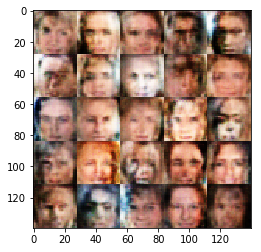

Epoch 1/1... Discriminator Loss: 1.5275... Generator Loss: 0.7161
Epoch 1/1... Discriminator Loss: 1.4825... Generator Loss: 0.8877
Epoch 1/1... Discriminator Loss: 1.3793... Generator Loss: 0.8572
Epoch 1/1... Discriminator Loss: 1.3639... Generator Loss: 0.8099
Epoch 1/1... Discriminator Loss: 1.3716... Generator Loss: 0.9011
Epoch 1/1... Discriminator Loss: 1.3327... Generator Loss: 0.8385
Epoch 1/1... Discriminator Loss: 1.4303... Generator Loss: 0.9307
Epoch 1/1... Discriminator Loss: 1.4250... Generator Loss: 0.9456
Epoch 1/1... Discriminator Loss: 1.2477... Generator Loss: 0.9300
Epoch 1/1... Discriminator Loss: 1.4152... Generator Loss: 0.7791


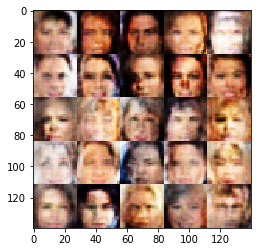

Epoch 1/1... Discriminator Loss: 1.4561... Generator Loss: 0.8204
Epoch 1/1... Discriminator Loss: 1.5688... Generator Loss: 0.8718
Epoch 1/1... Discriminator Loss: 1.4632... Generator Loss: 0.8270
Epoch 1/1... Discriminator Loss: 1.4355... Generator Loss: 0.7918
Epoch 1/1... Discriminator Loss: 1.2913... Generator Loss: 0.7864
Epoch 1/1... Discriminator Loss: 1.3880... Generator Loss: 0.8284
Epoch 1/1... Discriminator Loss: 1.5032... Generator Loss: 0.8005
Epoch 1/1... Discriminator Loss: 1.4117... Generator Loss: 0.9040
Epoch 1/1... Discriminator Loss: 1.3510... Generator Loss: 0.9253
Epoch 1/1... Discriminator Loss: 1.3311... Generator Loss: 0.8266


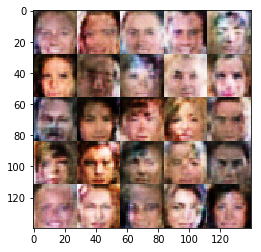

Epoch 1/1... Discriminator Loss: 1.3586... Generator Loss: 0.9017
Epoch 1/1... Discriminator Loss: 1.3213... Generator Loss: 0.8048
Epoch 1/1... Discriminator Loss: 1.4023... Generator Loss: 0.8510
Epoch 1/1... Discriminator Loss: 1.2814... Generator Loss: 0.9164
Epoch 1/1... Discriminator Loss: 1.3013... Generator Loss: 0.7093
Epoch 1/1... Discriminator Loss: 1.5089... Generator Loss: 0.8572
Epoch 1/1... Discriminator Loss: 1.4731... Generator Loss: 0.8700
Epoch 1/1... Discriminator Loss: 1.3405... Generator Loss: 0.8338
Epoch 1/1... Discriminator Loss: 1.3299... Generator Loss: 0.9658
Epoch 1/1... Discriminator Loss: 1.4511... Generator Loss: 0.8869


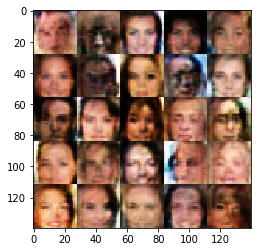

Epoch 1/1... Discriminator Loss: 1.3873... Generator Loss: 0.7830
Epoch 1/1... Discriminator Loss: 1.3666... Generator Loss: 0.9068
Epoch 1/1... Discriminator Loss: 1.3052... Generator Loss: 0.9008
Epoch 1/1... Discriminator Loss: 1.4245... Generator Loss: 0.7672
Epoch 1/1... Discriminator Loss: 1.4003... Generator Loss: 0.8556
Epoch 1/1... Discriminator Loss: 1.3948... Generator Loss: 0.8550
Epoch 1/1... Discriminator Loss: 1.3636... Generator Loss: 0.9520
Epoch 1/1... Discriminator Loss: 1.4608... Generator Loss: 0.7793
Epoch 1/1... Discriminator Loss: 1.4707... Generator Loss: 0.8481
Epoch 1/1... Discriminator Loss: 1.4991... Generator Loss: 0.7951


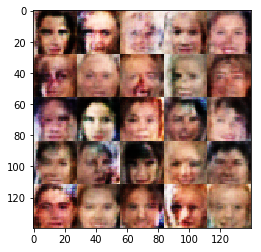

Epoch 1/1... Discriminator Loss: 1.3240... Generator Loss: 0.8600
Epoch 1/1... Discriminator Loss: 1.3693... Generator Loss: 0.9151
Epoch 1/1... Discriminator Loss: 1.4073... Generator Loss: 0.8347
Epoch 1/1... Discriminator Loss: 1.4327... Generator Loss: 0.9311
Epoch 1/1... Discriminator Loss: 1.4025... Generator Loss: 0.8887
Epoch 1/1... Discriminator Loss: 1.3749... Generator Loss: 1.0683
Epoch 1/1... Discriminator Loss: 1.3093... Generator Loss: 0.8529
Epoch 1/1... Discriminator Loss: 1.4949... Generator Loss: 0.8557
Epoch 1/1... Discriminator Loss: 1.3980... Generator Loss: 0.9806
Epoch 1/1... Discriminator Loss: 1.3982... Generator Loss: 0.8344


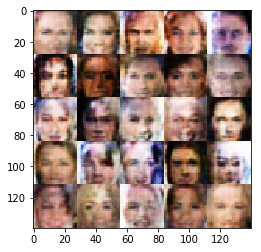

Epoch 1/1... Discriminator Loss: 1.4854... Generator Loss: 0.8827
Epoch 1/1... Discriminator Loss: 1.3474... Generator Loss: 0.9058
Epoch 1/1... Discriminator Loss: 1.4283... Generator Loss: 0.7409
Epoch 1/1... Discriminator Loss: 1.3617... Generator Loss: 0.8671
Epoch 1/1... Discriminator Loss: 1.3848... Generator Loss: 0.9420
Epoch 1/1... Discriminator Loss: 1.3313... Generator Loss: 0.8854
Epoch 1/1... Discriminator Loss: 1.4427... Generator Loss: 0.8433
Epoch 1/1... Discriminator Loss: 1.3100... Generator Loss: 0.8418
Epoch 1/1... Discriminator Loss: 1.4484... Generator Loss: 0.9009
Epoch 1/1... Discriminator Loss: 1.3088... Generator Loss: 0.8319


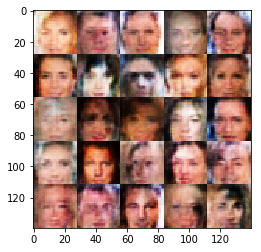

Epoch 1/1... Discriminator Loss: 1.2856... Generator Loss: 0.8568
Epoch 1/1... Discriminator Loss: 1.4174... Generator Loss: 0.8014
Epoch 1/1... Discriminator Loss: 1.3480... Generator Loss: 0.7922
Epoch 1/1... Discriminator Loss: 1.3467... Generator Loss: 0.8420
Epoch 1/1... Discriminator Loss: 1.5373... Generator Loss: 0.8274
Epoch 1/1... Discriminator Loss: 1.3710... Generator Loss: 0.9147
Epoch 1/1... Discriminator Loss: 1.3933... Generator Loss: 0.9401
Epoch 1/1... Discriminator Loss: 1.4657... Generator Loss: 0.8799
Epoch 1/1... Discriminator Loss: 1.2934... Generator Loss: 0.8379
Epoch 1/1... Discriminator Loss: 1.2464... Generator Loss: 0.8677


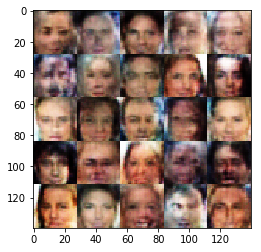

Epoch 1/1... Discriminator Loss: 1.3320... Generator Loss: 0.8365
Epoch 1/1... Discriminator Loss: 1.3495... Generator Loss: 0.7885
Epoch 1/1... Discriminator Loss: 1.3381... Generator Loss: 0.7664
Epoch 1/1... Discriminator Loss: 1.3292... Generator Loss: 0.8244
Epoch 1/1... Discriminator Loss: 1.4052... Generator Loss: 0.8298
Epoch 1/1... Discriminator Loss: 1.3534... Generator Loss: 0.7483
Epoch 1/1... Discriminator Loss: 1.4184... Generator Loss: 0.8286
Epoch 1/1... Discriminator Loss: 1.2920... Generator Loss: 0.8758
Epoch 1/1... Discriminator Loss: 1.3428... Generator Loss: 0.8759
Epoch 1/1... Discriminator Loss: 1.4023... Generator Loss: 0.8485


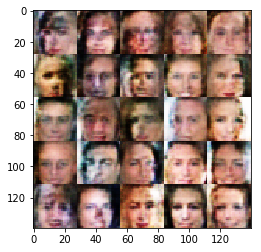

Epoch 1/1... Discriminator Loss: 1.6017... Generator Loss: 0.7658
Epoch 1/1... Discriminator Loss: 1.4561... Generator Loss: 0.8142
Epoch 1/1... Discriminator Loss: 1.4766... Generator Loss: 0.7377
Epoch 1/1... Discriminator Loss: 1.4514... Generator Loss: 0.8537
Epoch 1/1... Discriminator Loss: 1.3219... Generator Loss: 0.9204
Epoch 1/1... Discriminator Loss: 1.4183... Generator Loss: 0.7920
Epoch 1/1... Discriminator Loss: 1.3114... Generator Loss: 0.8485
Epoch 1/1... Discriminator Loss: 1.2132... Generator Loss: 0.8104
Epoch 1/1... Discriminator Loss: 1.3570... Generator Loss: 0.8483
Epoch 1/1... Discriminator Loss: 1.3061... Generator Loss: 0.8734


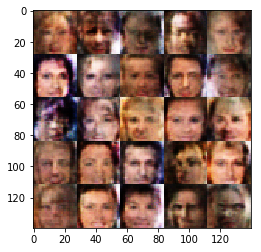

Epoch 1/1... Discriminator Loss: 1.4756... Generator Loss: 0.8461
Epoch 1/1... Discriminator Loss: 1.4327... Generator Loss: 0.7700
Epoch 1/1... Discriminator Loss: 1.2723... Generator Loss: 0.8908
Epoch 1/1... Discriminator Loss: 1.3662... Generator Loss: 0.8052
Epoch 1/1... Discriminator Loss: 1.4430... Generator Loss: 0.8652
Epoch 1/1... Discriminator Loss: 1.2765... Generator Loss: 0.8154
Epoch 1/1... Discriminator Loss: 1.5169... Generator Loss: 0.8210
Epoch 1/1... Discriminator Loss: 1.3291... Generator Loss: 0.8268
Epoch 1/1... Discriminator Loss: 1.3799... Generator Loss: 0.7808
Epoch 1/1... Discriminator Loss: 1.4165... Generator Loss: 0.8031


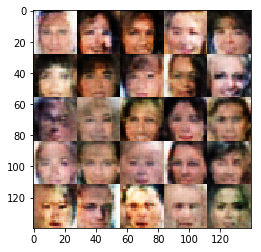

Epoch 1/1... Discriminator Loss: 1.3837... Generator Loss: 0.8183
Epoch 1/1... Discriminator Loss: 1.5480... Generator Loss: 0.7621
Epoch 1/1... Discriminator Loss: 1.4054... Generator Loss: 0.8475
Epoch 1/1... Discriminator Loss: 1.3767... Generator Loss: 0.8891
Epoch 1/1... Discriminator Loss: 1.2791... Generator Loss: 0.8579
Epoch 1/1... Discriminator Loss: 1.4312... Generator Loss: 0.9228
Epoch 1/1... Discriminator Loss: 1.3294... Generator Loss: 0.8375
Epoch 1/1... Discriminator Loss: 1.3383... Generator Loss: 0.9670
Epoch 1/1... Discriminator Loss: 1.3909... Generator Loss: 0.8109
Epoch 1/1... Discriminator Loss: 1.2441... Generator Loss: 0.8974


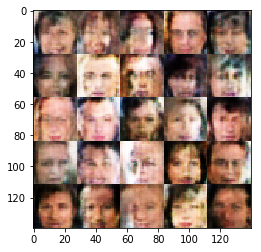

Epoch 1/1... Discriminator Loss: 1.3734... Generator Loss: 0.7599
Epoch 1/1... Discriminator Loss: 1.3799... Generator Loss: 0.8257
Epoch 1/1... Discriminator Loss: 1.4160... Generator Loss: 0.7795
Epoch 1/1... Discriminator Loss: 1.4491... Generator Loss: 0.7697
Epoch 1/1... Discriminator Loss: 1.2543... Generator Loss: 0.8129
Epoch 1/1... Discriminator Loss: 1.4820... Generator Loss: 0.8124
Epoch 1/1... Discriminator Loss: 1.3061... Generator Loss: 0.8525
Epoch 1/1... Discriminator Loss: 1.4076... Generator Loss: 0.8117
Epoch 1/1... Discriminator Loss: 1.3844... Generator Loss: 0.8913
Epoch 1/1... Discriminator Loss: 1.2757... Generator Loss: 0.8146


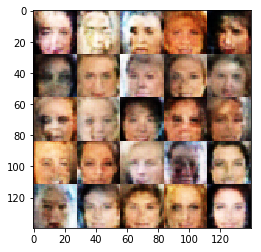

Epoch 1/1... Discriminator Loss: 1.3644... Generator Loss: 0.8515
Epoch 1/1... Discriminator Loss: 1.3612... Generator Loss: 0.8240
Epoch 1/1... Discriminator Loss: 1.3126... Generator Loss: 0.8460
Epoch 1/1... Discriminator Loss: 1.4456... Generator Loss: 0.7847
Epoch 1/1... Discriminator Loss: 1.3598... Generator Loss: 0.7722
Epoch 1/1... Discriminator Loss: 1.3733... Generator Loss: 0.8826
Epoch 1/1... Discriminator Loss: 1.3478... Generator Loss: 0.8808
Epoch 1/1... Discriminator Loss: 1.3437... Generator Loss: 0.8804
Epoch 1/1... Discriminator Loss: 1.3863... Generator Loss: 0.8309
Epoch 1/1... Discriminator Loss: 1.3219... Generator Loss: 0.8315


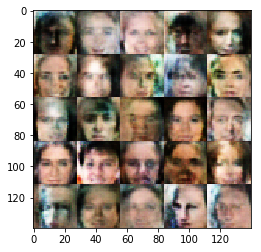

Epoch 1/1... Discriminator Loss: 1.5257... Generator Loss: 0.8596
Epoch 1/1... Discriminator Loss: 1.2710... Generator Loss: 0.8870
Epoch 1/1... Discriminator Loss: 1.2843... Generator Loss: 0.8876
Epoch 1/1... Discriminator Loss: 1.3951... Generator Loss: 0.8472
Epoch 1/1... Discriminator Loss: 1.3680... Generator Loss: 0.8821
Epoch 1/1... Discriminator Loss: 1.4684... Generator Loss: 0.7190
Epoch 1/1... Discriminator Loss: 1.3031... Generator Loss: 0.8995
Epoch 1/1... Discriminator Loss: 1.4274... Generator Loss: 0.7803
Epoch 1/1... Discriminator Loss: 1.5309... Generator Loss: 0.7347
Epoch 1/1... Discriminator Loss: 1.2659... Generator Loss: 0.8792


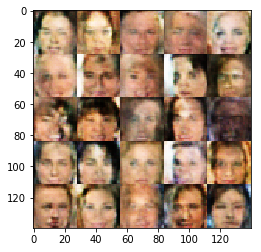

Epoch 1/1... Discriminator Loss: 1.3856... Generator Loss: 0.8472
Epoch 1/1... Discriminator Loss: 1.4345... Generator Loss: 0.8616
Epoch 1/1... Discriminator Loss: 1.3651... Generator Loss: 0.8547
Epoch 1/1... Discriminator Loss: 1.3366... Generator Loss: 0.9371
Epoch 1/1... Discriminator Loss: 1.3653... Generator Loss: 0.8213
Epoch 1/1... Discriminator Loss: 1.4807... Generator Loss: 0.8154
Epoch 1/1... Discriminator Loss: 1.2878... Generator Loss: 0.7782
Epoch 1/1... Discriminator Loss: 1.3082... Generator Loss: 0.8239
Epoch 1/1... Discriminator Loss: 1.3362... Generator Loss: 0.8724
Epoch 1/1... Discriminator Loss: 1.4908... Generator Loss: 0.7362


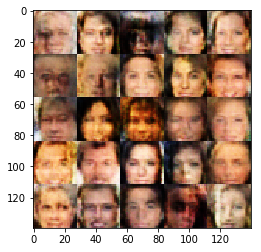

Epoch 1/1... Discriminator Loss: 1.3933... Generator Loss: 0.8721
Epoch 1/1... Discriminator Loss: 1.4934... Generator Loss: 0.8010
Epoch 1/1... Discriminator Loss: 1.3090... Generator Loss: 0.8745
Epoch 1/1... Discriminator Loss: 1.4105... Generator Loss: 0.8980
Epoch 1/1... Discriminator Loss: 1.3684... Generator Loss: 0.8258
Epoch 1/1... Discriminator Loss: 1.2726... Generator Loss: 0.8008
Epoch 1/1... Discriminator Loss: 1.2921... Generator Loss: 0.8938
Epoch 1/1... Discriminator Loss: 1.2571... Generator Loss: 0.7598
Epoch 1/1... Discriminator Loss: 1.4710... Generator Loss: 0.7651
Epoch 1/1... Discriminator Loss: 1.4281... Generator Loss: 0.7556


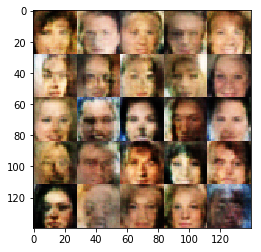

Epoch 1/1... Discriminator Loss: 1.2805... Generator Loss: 0.7755
Epoch 1/1... Discriminator Loss: 1.4100... Generator Loss: 0.7894
Epoch 1/1... Discriminator Loss: 1.4893... Generator Loss: 0.8538
Epoch 1/1... Discriminator Loss: 1.2892... Generator Loss: 0.8838
Epoch 1/1... Discriminator Loss: 1.3647... Generator Loss: 0.8768
Epoch 1/1... Discriminator Loss: 1.4285... Generator Loss: 0.7672
Epoch 1/1... Discriminator Loss: 1.4492... Generator Loss: 0.7601
Epoch 1/1... Discriminator Loss: 1.4090... Generator Loss: 0.8238
Epoch 1/1... Discriminator Loss: 1.3863... Generator Loss: 0.8399
Epoch 1/1... Discriminator Loss: 1.3762... Generator Loss: 0.8064


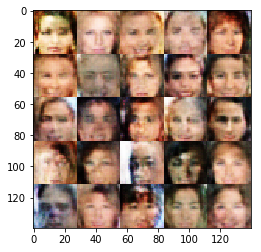

Epoch 1/1... Discriminator Loss: 1.3840... Generator Loss: 0.8795
Epoch 1/1... Discriminator Loss: 1.3548... Generator Loss: 0.8344
Epoch 1/1... Discriminator Loss: 1.4525... Generator Loss: 0.8186
Epoch 1/1... Discriminator Loss: 1.3816... Generator Loss: 0.8688
Epoch 1/1... Discriminator Loss: 1.3135... Generator Loss: 0.8759
Epoch 1/1... Discriminator Loss: 1.4333... Generator Loss: 0.7615
Epoch 1/1... Discriminator Loss: 1.3138... Generator Loss: 0.8937
Epoch 1/1... Discriminator Loss: 1.4382... Generator Loss: 0.8270
Epoch 1/1... Discriminator Loss: 1.3426... Generator Loss: 0.9144
Epoch 1/1... Discriminator Loss: 1.2491... Generator Loss: 0.9037


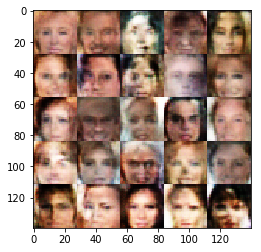

Epoch 1/1... Discriminator Loss: 1.3888... Generator Loss: 0.8857
Epoch 1/1... Discriminator Loss: 1.4080... Generator Loss: 0.9620
Epoch 1/1... Discriminator Loss: 1.4099... Generator Loss: 0.8049
Epoch 1/1... Discriminator Loss: 1.2861... Generator Loss: 0.9006
Epoch 1/1... Discriminator Loss: 1.2948... Generator Loss: 0.7878
Epoch 1/1... Discriminator Loss: 1.4554... Generator Loss: 0.7393
Epoch 1/1... Discriminator Loss: 1.2932... Generator Loss: 0.9501
Epoch 1/1... Discriminator Loss: 1.3255... Generator Loss: 0.8083
Epoch 1/1... Discriminator Loss: 1.3585... Generator Loss: 0.8505
Epoch 1/1... Discriminator Loss: 1.4707... Generator Loss: 0.7704


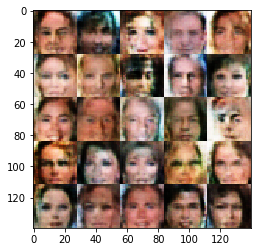

Epoch 1/1... Discriminator Loss: 1.4436... Generator Loss: 0.7820
Epoch 1/1... Discriminator Loss: 1.2877... Generator Loss: 0.8012
Epoch 1/1... Discriminator Loss: 1.2295... Generator Loss: 0.8154
Epoch 1/1... Discriminator Loss: 1.3284... Generator Loss: 0.9561
Epoch 1/1... Discriminator Loss: 1.3934... Generator Loss: 0.9234
Epoch 1/1... Discriminator Loss: 1.3333... Generator Loss: 0.8310
Epoch 1/1... Discriminator Loss: 1.3783... Generator Loss: 0.8204
Epoch 1/1... Discriminator Loss: 1.2491... Generator Loss: 0.8753
Epoch 1/1... Discriminator Loss: 1.3554... Generator Loss: 0.7876
Epoch 1/1... Discriminator Loss: 1.3660... Generator Loss: 0.7238


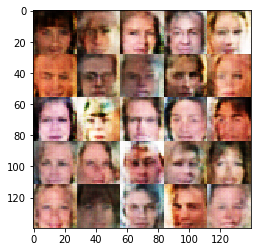

Epoch 1/1... Discriminator Loss: 1.4024... Generator Loss: 0.8113
Epoch 1/1... Discriminator Loss: 1.3261... Generator Loss: 0.7972
Epoch 1/1... Discriminator Loss: 1.4086... Generator Loss: 0.8483
Epoch 1/1... Discriminator Loss: 1.2977... Generator Loss: 0.9116
Epoch 1/1... Discriminator Loss: 1.3246... Generator Loss: 0.9027
Epoch 1/1... Discriminator Loss: 1.3603... Generator Loss: 0.8670
Epoch 1/1... Discriminator Loss: 1.2612... Generator Loss: 0.8845
Epoch 1/1... Discriminator Loss: 1.2673... Generator Loss: 0.9229
Epoch 1/1... Discriminator Loss: 1.2336... Generator Loss: 1.1182
Epoch 1/1... Discriminator Loss: 1.1648... Generator Loss: 1.0076


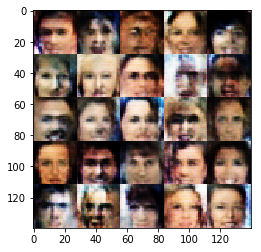

Epoch 1/1... Discriminator Loss: 0.8965... Generator Loss: 1.7505
Epoch 1/1... Discriminator Loss: 1.0035... Generator Loss: 1.2346
Epoch 1/1... Discriminator Loss: 0.7598... Generator Loss: 1.2025
Epoch 1/1... Discriminator Loss: 0.6954... Generator Loss: 1.5835
Epoch 1/1... Discriminator Loss: 1.0252... Generator Loss: 1.5827
Epoch 1/1... Discriminator Loss: 0.9668... Generator Loss: 1.7451
Epoch 1/1... Discriminator Loss: 1.1067... Generator Loss: 0.8760
Epoch 1/1... Discriminator Loss: 1.4427... Generator Loss: 0.7694
Epoch 1/1... Discriminator Loss: 1.2357... Generator Loss: 0.8891
Epoch 1/1... Discriminator Loss: 0.9745... Generator Loss: 0.9087


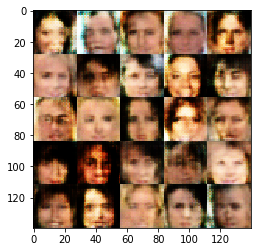

Epoch 1/1... Discriminator Loss: 1.6333... Generator Loss: 0.4849
Epoch 1/1... Discriminator Loss: 1.1435... Generator Loss: 0.8560
Epoch 1/1... Discriminator Loss: 1.3969... Generator Loss: 0.8865
Epoch 1/1... Discriminator Loss: 0.9050... Generator Loss: 1.5035
Epoch 1/1... Discriminator Loss: 1.4795... Generator Loss: 0.8109
Epoch 1/1... Discriminator Loss: 1.5419... Generator Loss: 0.7180
Epoch 1/1... Discriminator Loss: 1.2837... Generator Loss: 0.7231
Epoch 1/1... Discriminator Loss: 1.3170... Generator Loss: 1.0167
Epoch 1/1... Discriminator Loss: 1.3311... Generator Loss: 0.9056
Epoch 1/1... Discriminator Loss: 1.1963... Generator Loss: 0.9220


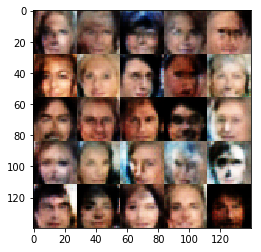

Epoch 1/1... Discriminator Loss: 0.9948... Generator Loss: 2.0136
Epoch 1/1... Discriminator Loss: 1.2780... Generator Loss: 0.8383
Epoch 1/1... Discriminator Loss: 1.3812... Generator Loss: 0.7524
Epoch 1/1... Discriminator Loss: 1.2674... Generator Loss: 0.7475
Epoch 1/1... Discriminator Loss: 1.2959... Generator Loss: 0.6754
Epoch 1/1... Discriminator Loss: 1.3704... Generator Loss: 0.6615
Epoch 1/1... Discriminator Loss: 1.0572... Generator Loss: 1.2967
Epoch 1/1... Discriminator Loss: 1.4187... Generator Loss: 0.8137
Epoch 1/1... Discriminator Loss: 1.4416... Generator Loss: 1.4128
Epoch 1/1... Discriminator Loss: 1.2697... Generator Loss: 0.7574


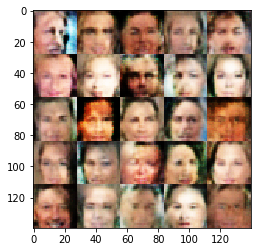

Epoch 1/1... Discriminator Loss: 1.2680... Generator Loss: 1.2326
Epoch 1/1... Discriminator Loss: 1.1759... Generator Loss: 1.0888
Epoch 1/1... Discriminator Loss: 1.0452... Generator Loss: 1.0235
Epoch 1/1... Discriminator Loss: 1.3293... Generator Loss: 0.7111
Epoch 1/1... Discriminator Loss: 1.2177... Generator Loss: 0.9527
Epoch 1/1... Discriminator Loss: 1.0256... Generator Loss: 1.1704
Epoch 1/1... Discriminator Loss: 1.2935... Generator Loss: 0.9416
Epoch 1/1... Discriminator Loss: 1.1721... Generator Loss: 0.9869
Epoch 1/1... Discriminator Loss: 1.3063... Generator Loss: 1.0861
Epoch 1/1... Discriminator Loss: 1.2959... Generator Loss: 1.1222


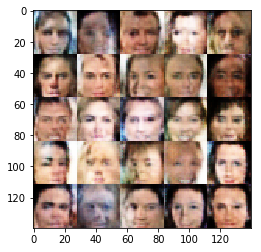

Epoch 1/1... Discriminator Loss: 1.2053... Generator Loss: 1.2723
Epoch 1/1... Discriminator Loss: 1.2783... Generator Loss: 1.3221
Epoch 1/1... Discriminator Loss: 1.4264... Generator Loss: 0.8279
Epoch 1/1... Discriminator Loss: 1.2764... Generator Loss: 0.8475
Epoch 1/1... Discriminator Loss: 1.2917... Generator Loss: 0.8832
Epoch 1/1... Discriminator Loss: 1.0431... Generator Loss: 1.1324
Epoch 1/1... Discriminator Loss: 1.4432... Generator Loss: 0.8179
Epoch 1/1... Discriminator Loss: 1.3601... Generator Loss: 0.8048
Epoch 1/1... Discriminator Loss: 0.9565... Generator Loss: 1.4704
Epoch 1/1... Discriminator Loss: 1.3461... Generator Loss: 0.7960


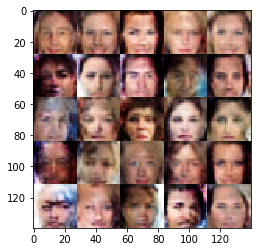

Epoch 1/1... Discriminator Loss: 1.3191... Generator Loss: 0.9379
Epoch 1/1... Discriminator Loss: 1.4064... Generator Loss: 0.7632
Epoch 1/1... Discriminator Loss: 1.4034... Generator Loss: 1.0674
Epoch 1/1... Discriminator Loss: 1.4664... Generator Loss: 0.6257
Epoch 1/1... Discriminator Loss: 1.4524... Generator Loss: 0.7883
Epoch 1/1... Discriminator Loss: 1.2907... Generator Loss: 0.8544
Epoch 1/1... Discriminator Loss: 1.5939... Generator Loss: 0.8009
Epoch 1/1... Discriminator Loss: 1.2970... Generator Loss: 0.8146
Epoch 1/1... Discriminator Loss: 1.4305... Generator Loss: 0.7540
Epoch 1/1... Discriminator Loss: 1.2688... Generator Loss: 0.8730


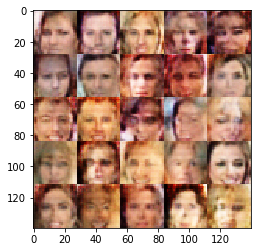

Epoch 1/1... Discriminator Loss: 1.2523... Generator Loss: 0.9002
Epoch 1/1... Discriminator Loss: 1.2462... Generator Loss: 0.9221
Epoch 1/1... Discriminator Loss: 1.1747... Generator Loss: 1.1222
Epoch 1/1... Discriminator Loss: 1.2474... Generator Loss: 0.8886
Epoch 1/1... Discriminator Loss: 1.3459... Generator Loss: 0.6795
Epoch 1/1... Discriminator Loss: 1.4113... Generator Loss: 0.8685
Epoch 1/1... Discriminator Loss: 1.5489... Generator Loss: 0.6141
Epoch 1/1... Discriminator Loss: 1.3568... Generator Loss: 0.8652
Epoch 1/1... Discriminator Loss: 1.5397... Generator Loss: 0.7315
Epoch 1/1... Discriminator Loss: 1.3985... Generator Loss: 0.8506


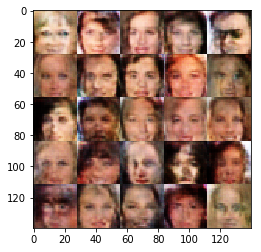

Epoch 1/1... Discriminator Loss: 1.4022... Generator Loss: 0.7346
Epoch 1/1... Discriminator Loss: 1.2234... Generator Loss: 1.0036
Epoch 1/1... Discriminator Loss: 1.3016... Generator Loss: 0.9181
Epoch 1/1... Discriminator Loss: 1.3288... Generator Loss: 0.8171
Epoch 1/1... Discriminator Loss: 1.3007... Generator Loss: 0.7982
Epoch 1/1... Discriminator Loss: 1.1633... Generator Loss: 0.9492
Epoch 1/1... Discriminator Loss: 1.6049... Generator Loss: 0.6581
Epoch 1/1... Discriminator Loss: 1.2987... Generator Loss: 0.9213
Epoch 1/1... Discriminator Loss: 1.5319... Generator Loss: 0.7385
Epoch 1/1... Discriminator Loss: 1.3982... Generator Loss: 0.7116


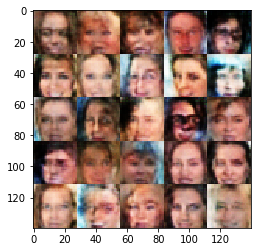

Epoch 1/1... Discriminator Loss: 1.3916... Generator Loss: 0.6886
Epoch 1/1... Discriminator Loss: 1.4238... Generator Loss: 0.9282
Epoch 1/1... Discriminator Loss: 1.4862... Generator Loss: 0.7859
Epoch 1/1... Discriminator Loss: 1.3513... Generator Loss: 1.0394
Epoch 1/1... Discriminator Loss: 1.2789... Generator Loss: 0.9877
Epoch 1/1... Discriminator Loss: 1.3098... Generator Loss: 0.8899
Epoch 1/1... Discriminator Loss: 1.4147... Generator Loss: 0.7464
Epoch 1/1... Discriminator Loss: 1.2484... Generator Loss: 0.8777
Epoch 1/1... Discriminator Loss: 1.3659... Generator Loss: 0.9923
Epoch 1/1... Discriminator Loss: 1.3371... Generator Loss: 0.9203


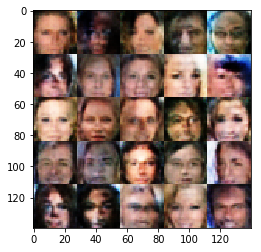

Epoch 1/1... Discriminator Loss: 1.5819... Generator Loss: 0.6511
Epoch 1/1... Discriminator Loss: 1.4335... Generator Loss: 0.6824
Epoch 1/1... Discriminator Loss: 1.3833... Generator Loss: 0.7154
Epoch 1/1... Discriminator Loss: 1.1468... Generator Loss: 1.0365
Epoch 1/1... Discriminator Loss: 1.4995... Generator Loss: 0.7741
Epoch 1/1... Discriminator Loss: 1.6743... Generator Loss: 0.6426
Epoch 1/1... Discriminator Loss: 1.3248... Generator Loss: 0.9471
Epoch 1/1... Discriminator Loss: 1.4541... Generator Loss: 0.7928
Epoch 1/1... Discriminator Loss: 1.3353... Generator Loss: 0.9391
Epoch 1/1... Discriminator Loss: 1.3399... Generator Loss: 0.7909


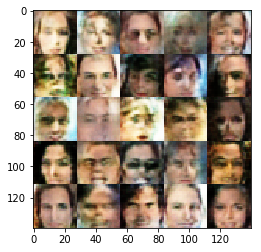

Epoch 1/1... Discriminator Loss: 1.4919... Generator Loss: 0.6574
Epoch 1/1... Discriminator Loss: 1.4561... Generator Loss: 0.6850
Epoch 1/1... Discriminator Loss: 1.3491... Generator Loss: 0.8728
Epoch 1/1... Discriminator Loss: 1.3355... Generator Loss: 0.8086
Epoch 1/1... Discriminator Loss: 1.5367... Generator Loss: 0.7590
Epoch 1/1... Discriminator Loss: 1.3997... Generator Loss: 0.8446
Epoch 1/1... Discriminator Loss: 1.3330... Generator Loss: 0.9044
Epoch 1/1... Discriminator Loss: 1.2975... Generator Loss: 0.9324
Epoch 1/1... Discriminator Loss: 1.2655... Generator Loss: 0.8352
Epoch 1/1... Discriminator Loss: 1.3483... Generator Loss: 0.8218


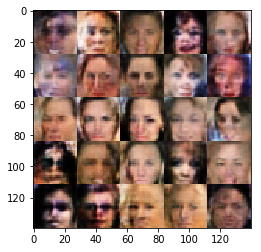

Epoch 1/1... Discriminator Loss: 1.3937... Generator Loss: 0.7452
Epoch 1/1... Discriminator Loss: 1.3216... Generator Loss: 0.8150
Epoch 1/1... Discriminator Loss: 1.4643... Generator Loss: 0.7342
Epoch 1/1... Discriminator Loss: 1.2907... Generator Loss: 0.7520
Epoch 1/1... Discriminator Loss: 1.3095... Generator Loss: 0.9710
Epoch 1/1... Discriminator Loss: 1.3856... Generator Loss: 0.8808
Epoch 1/1... Discriminator Loss: 1.2771... Generator Loss: 0.9297
Epoch 1/1... Discriminator Loss: 1.2332... Generator Loss: 0.9105
Epoch 1/1... Discriminator Loss: 1.3569... Generator Loss: 0.9311
Epoch 1/1... Discriminator Loss: 1.2848... Generator Loss: 0.9464


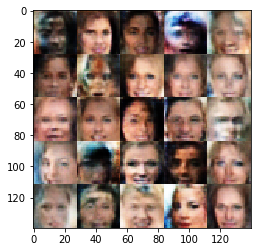

Epoch 1/1... Discriminator Loss: 1.4204... Generator Loss: 0.7852
Epoch 1/1... Discriminator Loss: 1.4232... Generator Loss: 0.7261
Epoch 1/1... Discriminator Loss: 1.4587... Generator Loss: 0.7354
Epoch 1/1... Discriminator Loss: 1.3085... Generator Loss: 0.8320
Epoch 1/1... Discriminator Loss: 1.3671... Generator Loss: 0.8732
Epoch 1/1... Discriminator Loss: 1.3586... Generator Loss: 0.8759
Epoch 1/1... Discriminator Loss: 1.3372... Generator Loss: 0.7871
Epoch 1/1... Discriminator Loss: 1.4648... Generator Loss: 0.7692
Epoch 1/1... Discriminator Loss: 1.2815... Generator Loss: 0.8450
Epoch 1/1... Discriminator Loss: 1.5529... Generator Loss: 0.6997


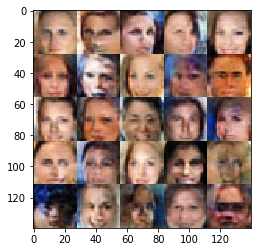

Epoch 1/1... Discriminator Loss: 1.3084... Generator Loss: 0.8874
Epoch 1/1... Discriminator Loss: 1.3782... Generator Loss: 0.7623
Epoch 1/1... Discriminator Loss: 1.4931... Generator Loss: 0.9042
Epoch 1/1... Discriminator Loss: 1.2522... Generator Loss: 0.7931
Epoch 1/1... Discriminator Loss: 1.4549... Generator Loss: 0.7729
Epoch 1/1... Discriminator Loss: 1.2992... Generator Loss: 0.7500
Epoch 1/1... Discriminator Loss: 1.3838... Generator Loss: 0.8026
Epoch 1/1... Discriminator Loss: 1.2733... Generator Loss: 0.8197
Epoch 1/1... Discriminator Loss: 1.3962... Generator Loss: 0.9325
Epoch 1/1... Discriminator Loss: 1.3227... Generator Loss: 0.7857


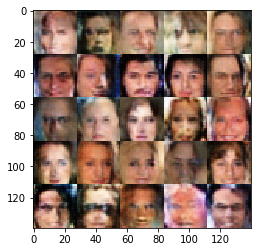

Epoch 1/1... Discriminator Loss: 1.3698... Generator Loss: 0.8636
Epoch 1/1... Discriminator Loss: 1.3487... Generator Loss: 0.7484
Epoch 1/1... Discriminator Loss: 1.3375... Generator Loss: 0.9085
Epoch 1/1... Discriminator Loss: 1.4876... Generator Loss: 0.8769
Epoch 1/1... Discriminator Loss: 1.3482... Generator Loss: 0.7786
Epoch 1/1... Discriminator Loss: 1.2702... Generator Loss: 0.8998
Epoch 1/1... Discriminator Loss: 1.5155... Generator Loss: 0.6130
Epoch 1/1... Discriminator Loss: 1.4381... Generator Loss: 0.7349
Epoch 1/1... Discriminator Loss: 1.4557... Generator Loss: 0.7449
Epoch 1/1... Discriminator Loss: 1.2526... Generator Loss: 0.8224


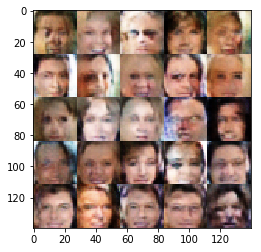

Epoch 1/1... Discriminator Loss: 1.2801... Generator Loss: 0.8203
Epoch 1/1... Discriminator Loss: 1.4376... Generator Loss: 0.7563
Epoch 1/1... Discriminator Loss: 1.2750... Generator Loss: 0.7809
Epoch 1/1... Discriminator Loss: 1.2524... Generator Loss: 0.9229
Epoch 1/1... Discriminator Loss: 1.4768... Generator Loss: 0.8472
Epoch 1/1... Discriminator Loss: 1.4062... Generator Loss: 0.8363
Epoch 1/1... Discriminator Loss: 1.3465... Generator Loss: 0.8117
Epoch 1/1... Discriminator Loss: 1.2818... Generator Loss: 0.9029
Epoch 1/1... Discriminator Loss: 1.1840... Generator Loss: 1.0883
Epoch 1/1... Discriminator Loss: 1.1443... Generator Loss: 0.8977


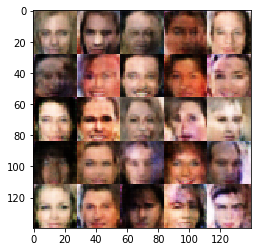

Epoch 1/1... Discriminator Loss: 1.2317... Generator Loss: 0.8792
Epoch 1/1... Discriminator Loss: 1.1870... Generator Loss: 1.0072
Epoch 1/1... Discriminator Loss: 1.4643... Generator Loss: 0.7425
Epoch 1/1... Discriminator Loss: 1.5469... Generator Loss: 0.6748
Epoch 1/1... Discriminator Loss: 1.2166... Generator Loss: 0.9144
Epoch 1/1... Discriminator Loss: 1.3241... Generator Loss: 0.7970
Epoch 1/1... Discriminator Loss: 1.3905... Generator Loss: 0.7923
Epoch 1/1... Discriminator Loss: 1.3298... Generator Loss: 0.8349
Epoch 1/1... Discriminator Loss: 1.3530... Generator Loss: 0.8470
Epoch 1/1... Discriminator Loss: 1.3451... Generator Loss: 0.8049


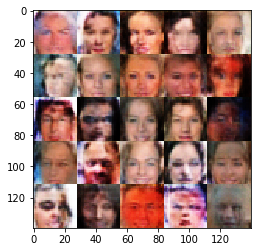

Epoch 1/1... Discriminator Loss: 1.3837... Generator Loss: 0.7535
Epoch 1/1... Discriminator Loss: 1.4661... Generator Loss: 0.6951
Epoch 1/1... Discriminator Loss: 1.3346... Generator Loss: 0.8360
Epoch 1/1... Discriminator Loss: 1.4087... Generator Loss: 0.9203
Epoch 1/1... Discriminator Loss: 1.2636... Generator Loss: 0.9417
Epoch 1/1... Discriminator Loss: 1.4678... Generator Loss: 0.7320
Epoch 1/1... Discriminator Loss: 1.5646... Generator Loss: 0.7192
Epoch 1/1... Discriminator Loss: 1.3913... Generator Loss: 0.8696
Epoch 1/1... Discriminator Loss: 1.3662... Generator Loss: 0.8101
Epoch 1/1... Discriminator Loss: 1.3793... Generator Loss: 0.8105


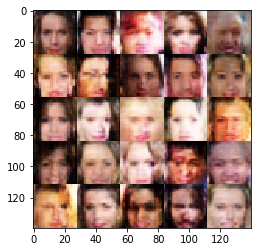

Epoch 1/1... Discriminator Loss: 1.4084... Generator Loss: 0.7380
Epoch 1/1... Discriminator Loss: 1.2247... Generator Loss: 0.8056
Epoch 1/1... Discriminator Loss: 1.5164... Generator Loss: 0.6961
Epoch 1/1... Discriminator Loss: 1.1725... Generator Loss: 1.1957
Epoch 1/1... Discriminator Loss: 1.5157... Generator Loss: 0.6815
Epoch 1/1... Discriminator Loss: 1.3642... Generator Loss: 0.7703
Epoch 1/1... Discriminator Loss: 1.3935... Generator Loss: 0.8428
Epoch 1/1... Discriminator Loss: 1.4715... Generator Loss: 0.7764
Epoch 1/1... Discriminator Loss: 1.3080... Generator Loss: 0.7987
Epoch 1/1... Discriminator Loss: 1.4828... Generator Loss: 0.8058


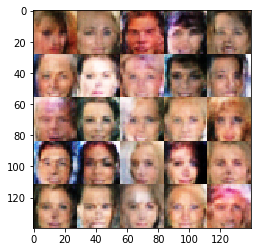

Epoch 1/1... Discriminator Loss: 1.2389... Generator Loss: 0.8990
Epoch 1/1... Discriminator Loss: 1.2214... Generator Loss: 0.8154
Epoch 1/1... Discriminator Loss: 1.2061... Generator Loss: 0.9726
Epoch 1/1... Discriminator Loss: 1.1724... Generator Loss: 1.0417
Epoch 1/1... Discriminator Loss: 1.2935... Generator Loss: 0.7878
Epoch 1/1... Discriminator Loss: 1.2931... Generator Loss: 0.7620
Epoch 1/1... Discriminator Loss: 1.3197... Generator Loss: 0.9765
Epoch 1/1... Discriminator Loss: 1.3094... Generator Loss: 0.9030
Epoch 1/1... Discriminator Loss: 1.2647... Generator Loss: 0.9015
Epoch 1/1... Discriminator Loss: 1.3487... Generator Loss: 0.8420


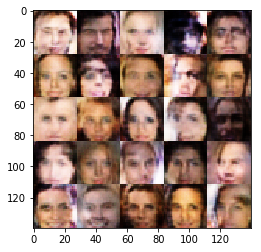

Epoch 1/1... Discriminator Loss: 1.5061... Generator Loss: 0.7067
Epoch 1/1... Discriminator Loss: 1.3504... Generator Loss: 0.8053
Epoch 1/1... Discriminator Loss: 1.3046... Generator Loss: 0.9533
Epoch 1/1... Discriminator Loss: 1.4158... Generator Loss: 0.8011
Epoch 1/1... Discriminator Loss: 1.3990... Generator Loss: 0.6833
Epoch 1/1... Discriminator Loss: 1.4108... Generator Loss: 0.8015
Epoch 1/1... Discriminator Loss: 1.3505... Generator Loss: 0.8370
Epoch 1/1... Discriminator Loss: 1.4092... Generator Loss: 0.8205
Epoch 1/1... Discriminator Loss: 1.3643... Generator Loss: 0.8024
Epoch 1/1... Discriminator Loss: 1.4076... Generator Loss: 0.6625


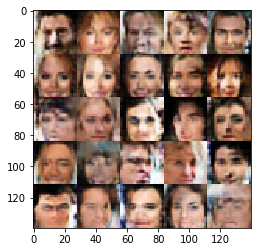

Epoch 1/1... Discriminator Loss: 1.3181... Generator Loss: 0.8932
Epoch 1/1... Discriminator Loss: 1.3903... Generator Loss: 0.7674
Epoch 1/1... Discriminator Loss: 1.3703... Generator Loss: 0.7731
Epoch 1/1... Discriminator Loss: 1.4561... Generator Loss: 0.7480
Epoch 1/1... Discriminator Loss: 1.3768... Generator Loss: 0.6170
Epoch 1/1... Discriminator Loss: 1.3095... Generator Loss: 0.9430
Epoch 1/1... Discriminator Loss: 1.3221... Generator Loss: 0.8831
Epoch 1/1... Discriminator Loss: 1.2926... Generator Loss: 0.8156
Epoch 1/1... Discriminator Loss: 1.2729... Generator Loss: 0.9355
Epoch 1/1... Discriminator Loss: 1.2880... Generator Loss: 0.9373


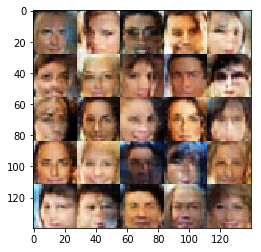

Epoch 1/1... Discriminator Loss: 1.3711... Generator Loss: 0.8200
Epoch 1/1... Discriminator Loss: 1.5430... Generator Loss: 0.8101
Epoch 1/1... Discriminator Loss: 1.2198... Generator Loss: 0.8397
Epoch 1/1... Discriminator Loss: 1.2526... Generator Loss: 0.8239
Epoch 1/1... Discriminator Loss: 1.1360... Generator Loss: 1.0034
Epoch 1/1... Discriminator Loss: 1.1182... Generator Loss: 0.8247
Epoch 1/1... Discriminator Loss: 1.4425... Generator Loss: 0.7324
Epoch 1/1... Discriminator Loss: 1.2993... Generator Loss: 0.8546
Epoch 1/1... Discriminator Loss: 1.3213... Generator Loss: 0.8535
Epoch 1/1... Discriminator Loss: 1.5094... Generator Loss: 0.6818


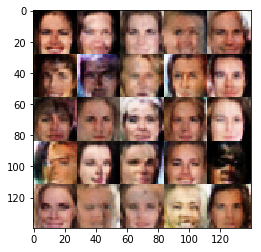

Epoch 1/1... Discriminator Loss: 1.4453... Generator Loss: 0.6834
Epoch 1/1... Discriminator Loss: 1.3894... Generator Loss: 0.6802
Epoch 1/1... Discriminator Loss: 1.0870... Generator Loss: 0.9414
Epoch 1/1... Discriminator Loss: 1.3511... Generator Loss: 0.7762
Epoch 1/1... Discriminator Loss: 1.3809... Generator Loss: 0.7527
Epoch 1/1... Discriminator Loss: 1.2998... Generator Loss: 0.7270
Epoch 1/1... Discriminator Loss: 1.3039... Generator Loss: 0.8488
Epoch 1/1... Discriminator Loss: 1.2821... Generator Loss: 0.7768
Epoch 1/1... Discriminator Loss: 1.3422... Generator Loss: 0.7825
Epoch 1/1... Discriminator Loss: 1.4241... Generator Loss: 0.8028


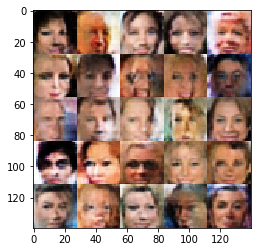

Epoch 1/1... Discriminator Loss: 1.3135... Generator Loss: 0.7971
Epoch 1/1... Discriminator Loss: 1.2442... Generator Loss: 0.7975
Epoch 1/1... Discriminator Loss: 1.2875... Generator Loss: 0.7864
Epoch 1/1... Discriminator Loss: 1.3611... Generator Loss: 0.7617
Epoch 1/1... Discriminator Loss: 1.2512... Generator Loss: 0.7498
Epoch 1/1... Discriminator Loss: 1.3797... Generator Loss: 0.6552
Epoch 1/1... Discriminator Loss: 1.2908... Generator Loss: 0.9088
Epoch 1/1... Discriminator Loss: 1.2482... Generator Loss: 1.0808
Epoch 1/1... Discriminator Loss: 1.1962... Generator Loss: 0.8658
Epoch 1/1... Discriminator Loss: 1.1993... Generator Loss: 1.0971


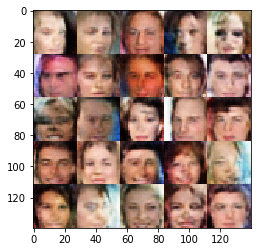

Epoch 1/1... Discriminator Loss: 1.3616... Generator Loss: 0.8273
Epoch 1/1... Discriminator Loss: 1.3771... Generator Loss: 0.6382
Epoch 1/1... Discriminator Loss: 1.3219... Generator Loss: 0.9041
Epoch 1/1... Discriminator Loss: 1.1001... Generator Loss: 1.5463
Epoch 1/1... Discriminator Loss: 1.4085... Generator Loss: 0.8317
Epoch 1/1... Discriminator Loss: 1.3689... Generator Loss: 0.9341
Epoch 1/1... Discriminator Loss: 1.5263... Generator Loss: 0.6235
Epoch 1/1... Discriminator Loss: 1.4550... Generator Loss: 0.8271
Epoch 1/1... Discriminator Loss: 1.3899... Generator Loss: 0.7951
Epoch 1/1... Discriminator Loss: 1.3432... Generator Loss: 0.7875


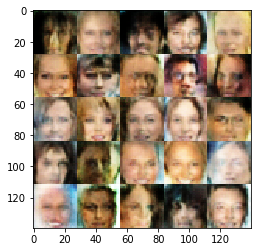

Epoch 1/1... Discriminator Loss: 1.1709... Generator Loss: 1.1763
Epoch 1/1... Discriminator Loss: 1.3274... Generator Loss: 0.6386
Epoch 1/1... Discriminator Loss: 1.2884... Generator Loss: 0.8671
Epoch 1/1... Discriminator Loss: 1.1073... Generator Loss: 1.8122
Epoch 1/1... Discriminator Loss: 1.3307... Generator Loss: 0.7748
Epoch 1/1... Discriminator Loss: 1.2262... Generator Loss: 1.0692
Epoch 1/1... Discriminator Loss: 1.5638... Generator Loss: 0.8080
Epoch 1/1... Discriminator Loss: 1.4315... Generator Loss: 0.6637
Epoch 1/1... Discriminator Loss: 1.3851... Generator Loss: 0.6611
Epoch 1/1... Discriminator Loss: 1.5876... Generator Loss: 0.6251


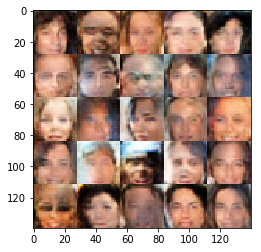

Epoch 1/1... Discriminator Loss: 1.4055... Generator Loss: 0.6659
Epoch 1/1... Discriminator Loss: 1.2175... Generator Loss: 0.8581
Epoch 1/1... Discriminator Loss: 1.4566... Generator Loss: 0.7840
Epoch 1/1... Discriminator Loss: 1.3727... Generator Loss: 0.8882
Epoch 1/1... Discriminator Loss: 1.1551... Generator Loss: 1.1818
Epoch 1/1... Discriminator Loss: 1.2049... Generator Loss: 1.0494
Epoch 1/1... Discriminator Loss: 1.2912... Generator Loss: 0.8585
Epoch 1/1... Discriminator Loss: 1.3278... Generator Loss: 0.7669
Epoch 1/1... Discriminator Loss: 0.9815... Generator Loss: 1.8239
Epoch 1/1... Discriminator Loss: 1.3525... Generator Loss: 0.8692


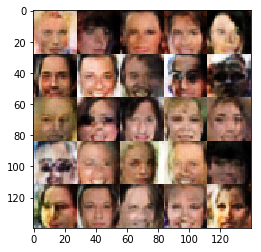

Epoch 1/1... Discriminator Loss: 1.4624... Generator Loss: 0.6758
Epoch 1/1... Discriminator Loss: 1.3300... Generator Loss: 0.7058
Epoch 1/1... Discriminator Loss: 1.4631... Generator Loss: 0.7757


In [16]:
batch_size = 32
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.